<a href="https://colab.research.google.com/github/flat35hd99/report_magnetical_material/blob/master/20200514magnetical_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 希土類元素Tb,Dy,Ho,Er,Tmの磁化測定  
氏名　杉浦航  
学籍番号　061800882  
希土類元素Tb,Dy,Ho,Er,Tmの磁化率の温度依存性($\frac{M}{H}$ vs T )・磁化の磁場依存性(M-Hcurve)を調べる。この実験では$\frac{dM}{dH}$ではなく$\frac{M}{H}$を磁化率（線形磁化率）とする。  
以下の処理は今後プログラムする上で必要になる処理である。numpyは多次元配列の処理に優れているライブラリ、matplotlibは図形描画を行うpython版gnuplotのようなライブラリである。なお、このレポートはGoogle Colabを利用して作成・実行した。Google colabはjupyter notebookをベースにしたpythonの実行環境である。



In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

dirPath = "/content/drive/My Drive/Colab Notebooks/Data_Magnetism/"
experiment_alpha = 4.228 * 10**2 # 第二回で求めたこの実験系でのα

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 問題（１）
室温と液体窒素温度におけるTb,Dy,Ho,Er,Tmの磁化の磁場依存性の測定データを使用してモル磁化M(emu/mol)を磁場H(Oe)に対してプロットしたグラフを作成せよ。  
Tb 質量:0.2105、式量:158.93 g/mol  
Dy 質量:0.1052、式量:162.05 g/mol  
Ho 質量:0.1374、式量:164.93 g/mol  
Er 質量:0.1338、式量:167.26 g/mol  
Tm 質量:0.1308、式量:168.93 g/mol  
## 回答
同じ処理を複数回するので、DataModuleクラスを定義して、H-Mカーブを簡単にプロットできるようにした。プロットの結果は下記の通りである。

In [0]:
# fittingに使用するため再利用可能な関数として定義。
def curie_weiss_low(t,curie_c,weiss_t):
    return (t-weiss_t)/curie_c
"""
(dirPath, substance_name, sample_mass, formula_weight)を引数に取る。
dirPath: データの格納してあるディレクトリへのパス
substance_name: 保存してあるディレクトリの名前。物質名。
sample_mass: 実験に使用した試料の質量 [g]
formula_weight: 試料の式量 [g/mol]
"""
class DataModule:
    
    substance_name = ''

    # T = 300 Kの一定温度で実験したときのデータ
    H_300K = []
    V_300K = []
    molar_magnetization_300K = []

    # T = 77 Kの一定温度で実験したときのデータ
    H_77K = []
    V_77K = []
    molar_magnetization_77K = []

    # H = 5000 Oeの一定磁場で実験したときのデータ
    H_5000_Oe = []
    T_5000_Oe = []
    V_5000_Oe = []
    
    def __init__(self, dirPath, substance_name, sample_mass, formula_weight):
        self.substance_name = substance_name

        self.H_300K, self.V_300K = np.loadtxt(dirPath + substance_name + '/M-H_' + substance_name + '_300K.txt', skiprows=1, unpack=True, usecols=[0,2])
        self.H_77K, self.V_77K = np.loadtxt(dirPath + substance_name + '/M-H_' + substance_name + '_77K.txt', skiprows=1, unpack=True, usecols=[0,2])
        self.H_5000_Oe, self.T_5000_Oe, self.V_5000_Oe = np.loadtxt(dirPath + substance_name + '/M-T_' + substance_name + '.txt', skiprows=1, unpack=True)

        sample_amount_of_substance = sample_mass / formula_weight
        self.molar_magnetization_300K = (experiment_alpha / sample_amount_of_substance) * self.V_300K
        self.molar_magnetization_77K = (experiment_alpha / sample_amount_of_substance) * self.V_77K
        self.molar_magnetization_5000_Oe = (experiment_alpha / sample_amount_of_substance) * self.V_5000_Oe

        # あとから代入したり定義する変数
        self.phase_transition_temperature = None

    def draw_mh_curve(self):
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(111)
        c1, c2 = "blue", "green" #プロットの色指定
        l1, l2 = "77K", "300K" # ラベルの名前指定
        # 軸ラベル指定
        ax.set_xlabel('H(Oe)')
        ax.set_ylabel('M(emu/mol)')
        ax.set_title('M-H curve( ' + self.substance_name + ' )')
        ax.grid() # 罫線を表示
        ax.plot(self.H_77K, self.molar_magnetization_77K, 'o-', color=c1, label=l1)
        ax.plot(self.H_300K,self.molar_magnetization_300K, 'o-', color=c2, label=l2)
        ax.legend(loc=0) # 凡例の表示
    
    def draw_mt_curve(self):
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(111)
        ax.set_xlabel('H(Oe)')
        ax.set_ylabel('M(emu/mol)')
        ax.set_title('M-T curve( ' + self.substance_name + ' )')
        ax.grid() # 罫線を表示
        ax.plot(self.molar_magnetization_5000_Oe, self.T_5000_Oe, 'o-', color="blue", label="5000(Oe)")
        ax.legend(loc=0)
    
    def draw_susceptibility(self):
        molar_susceptibility = self.molar_magnetization_5000_Oe/ self.H_5000_Oe

        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        ax.set_xlabel('T (K)')
        ax.set_ylabel('M/H (emu/mol)')
        ax.set_title('Molar susceptibility of ' + self.substance_name)
        ax.grid()
        ax.vlines(77,min(molar_susceptibility),max(molar_susceptibility),linestyle='dashed', linewidth=0.5, label='77 K')
        ax.plot(self.T_5000_Oe, molar_susceptibility, 'o-', color="blue", label="5000(Oe)")
        ax.legend(loc=0)
    
    def printMaxMinMolarMagnization(self):
        print("--- substance:",self.substance_name,"---")
        print("when T = 300K")
        print("max =",np.max(self.molar_magnetization_300K),'K')
        print("min =",np.min(self.molar_magnetization_300K),'K')
        print("when T = 77K")
        print("max =",np.max(self.molar_magnetization_77K),'K')
        print("min =",np.min(self.molar_magnetization_77K),"K\n")

    def fitting(self):
        index = np.where(self.T_5000_Oe > self.phase_transition_temperature)
        target_T = self.T_5000_Oe[index]
        target_M = self.molar_magnetization_5000_Oe[index]
        target_H = self.H_5000_Oe[index]
        inverse_susceptibility = target_H / target_M
        
        # param[0] = キュリー定数C
        # param[1] = ワイス温度T_θ
        param, cov = curve_fit(curie_weiss_low, target_T, inverse_susceptibility)

        curie_constant = param[0]
        weiss_temparature = param[1]

        fit_chi = []
        for t in target_T:
            fit_chi.append( (t-weiss_temparature)/curie_constant )
        
        # fitting の結果をグラフに示している。
        # データはプロットし、フィッティングした結果はなめらかな曲線で表している。
        sns.pointplot(x=target_T, y=inverse_susceptibility, join=False)
        sns.pointplot(x=target_T, y=np.array(fit_chi), markers="")
        print(self.substance_name)
        print('キュリー定数C =', curie_constant)
        print('ワイス温度T_θ =', weiss_temparature)
        print('有効磁子数 p_eff =', (8 * curie_constant)**(1/2))

    def draw_inverse_susceptibility(self):
        inverse_susceptibility = self.H_5000_Oe / self.molar_magnetization_5000_Oe

        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111)
        
        ax.set_xlabel('T(K)')
        ax.set_ylabel('H/M(emu\mol * Oe')
        ax.set_title('H/M-T curve ( ' + self.substance_name + ' )')
        ax.grid()

        ax.plot(self.T_5000_Oe, inverse_susceptibility, 'o-', color='blue', label='5000(Oe)')

各試料ごとにインスタンスを生成する。

In [0]:
Tb = DataModule(dirPath, 'Tb', 0.2105, 158.93)
Dy = DataModule(dirPath, 'Dy', 0.1052, 162.05)
Ho = DataModule(dirPath, 'Ho', 0.1374, 164.93)
Er = DataModule(dirPath, 'Er', 0.1338, 167.26)
Tm = DataModule(dirPath, 'Tm', 0.1308, 168.93)

プロットする。

--- substance: Tb ---
when T = 300K
max = 754.6337665368171 K
min = -747.2917290451308 K
when T = 77K
max = 22664.55051781473 K
min = -22405.98311049881 K

--- substance: Dy ---
when T = 300K
max = 467.61961330798476 K
min = -476.0862636882129 K
when T = 77K
max = 20893.088015209123 K
min = -20775.857471482886 K

--- substance: Ho ---
when T = 300K
max = 317.19616084425036 K
min = -323.28632713246 K
when T = 77K
max = 1766.1482235807862 K
min = -1816.899609315866 K

--- substance: Er ---
when T = 300K
max = 211.99402452017935 K
min = -214.84809515695065 K
when T = 77K
max = 1297.0165449327353 K
min = -1287.6615356233183 K

--- substance: Tm ---
when T = 300K
max = 129.19590754128438 K
min = -129.85116996330274 K
when T = 77K
max = 568.2763354954128 K
min = -571.0612007889907 K



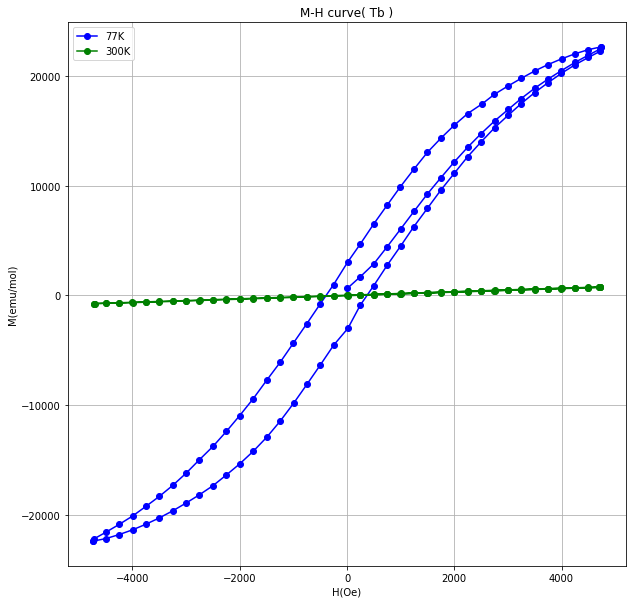

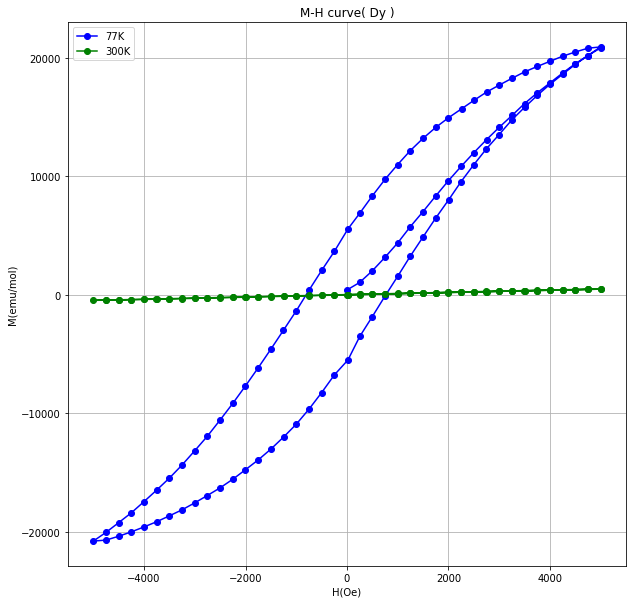

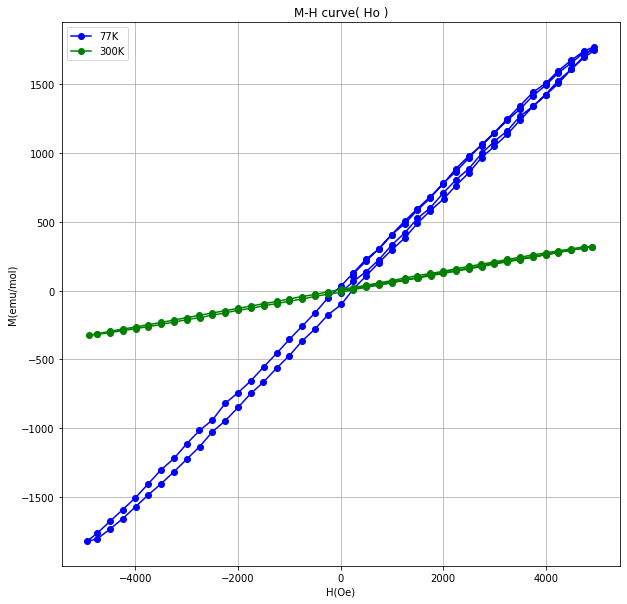

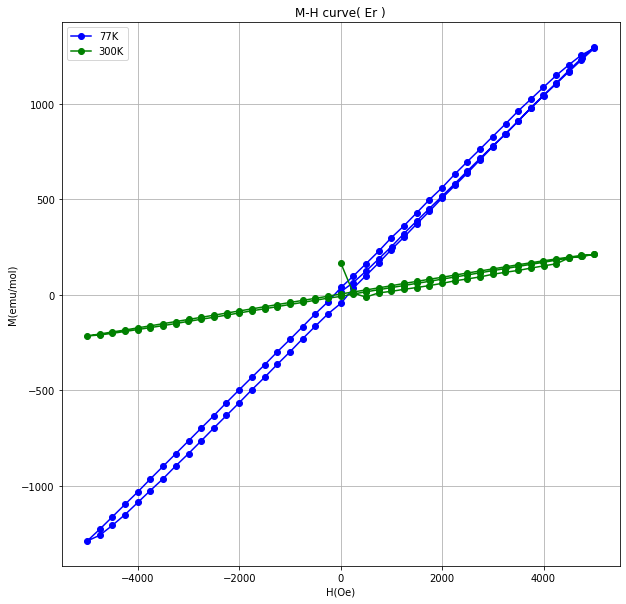

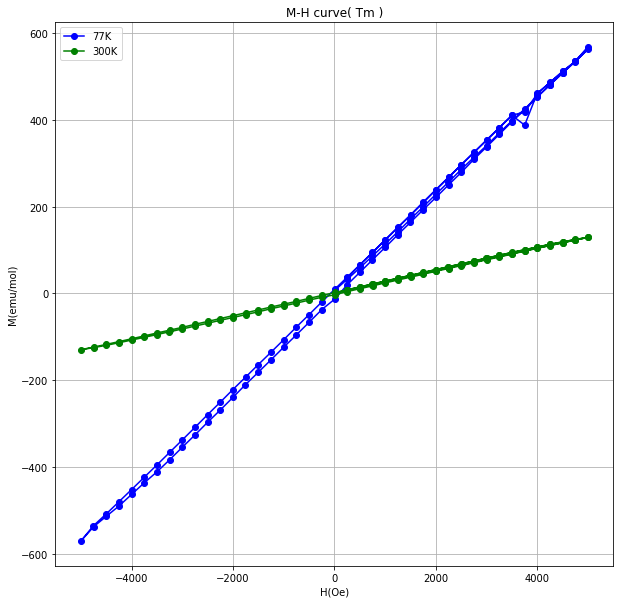

In [122]:
Tb.printMaxMinMolarMagnization()
Tb.draw_mh_curve()
Dy.printMaxMinMolarMagnization()
Dy.draw_mh_curve()
Ho.printMaxMinMolarMagnization()
Ho.draw_mh_curve()
Er.printMaxMinMolarMagnization()
Er.draw_mh_curve()
Tm.printMaxMinMolarMagnization()
Tm.draw_mh_curve()

# 問題（２）
室温と液体窒素温度におけるTb,Dy,Ho,Er,Tmの磁化の磁場依存性を比較し、磁化率の温度依存性も参考にして、磁化の磁場依存性の特徴から、液体窒素温度におけるTb,Dy,Ho,Er,Tmの磁気状態（磁性）を推定せよ。
## 回答
### Tb（テルビウム）
M-H curveで履歴現象も確認されることから、強磁性であることがわかる。問題（３）でモル磁化率を温度に対してプロットしたグラフにて、液体窒素温度付近では高い値をとっていることからも判断できる。
### Dy（ジスプロシウム）
テルビウムに同じく、M-H curveでの履歴現象と液体窒素温度でのモル磁化率の値が大きいことから強磁性と判断できる。
### Ho（ホルミウム）
M-H curveで履歴現象が確認されず、また、液体窒素温度でのモル磁化率の値が小さいことから、反強磁性と判断できる。
### Er（エルビウム）
Hoに同じ
### Tm（ツリウム）
Hoに同じ

# 問題（３）
磁場H= 5000 (Oe)を印可して測定したTb,Dy,Ho,Er,TmのM/H（線形磁化率）の温度依存性の測定デー
タを使用してモル磁化率M/H(emu/mol)を温度T(K)に対してプロットしたグラフを作成せよ。
降温時に磁化率が急激に増大する温度（Gdの磁化率の温度依存性のグラフの変曲点）から磁気相転移温度（T<sub>C</sub> = (g<sub>J</sub> - 1）<sup>2</sup> |J<sub>eff</sub>|J(J+1)/3k<sub>B</sub> : キュリー温度）、降温時に磁化率の増大が変化（ピーク、キンクが出
現）する温度から反強磁性・らせん磁性転移温度（T<sub>N</sub> = (g<sub>J</sub> - 1 )<sup>2</sup> |J<sub>eff</sub>|J(J+1)/3k<sub>B</sub> : ネール温度) を求めよ。

## 回答
プロットした結果は以下の通りである。

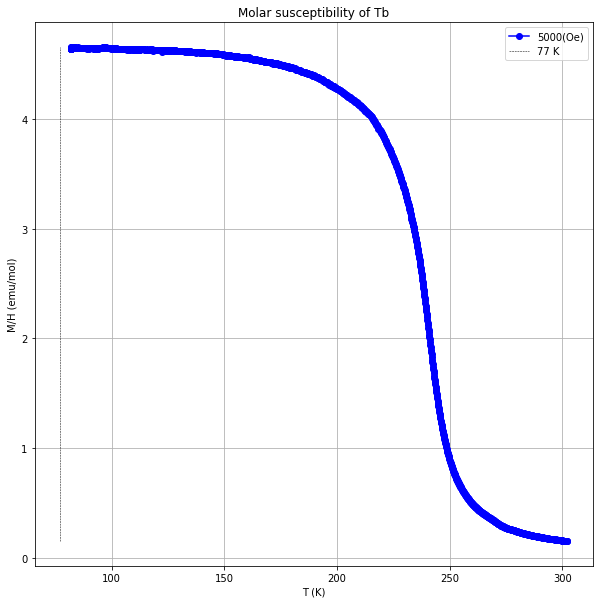

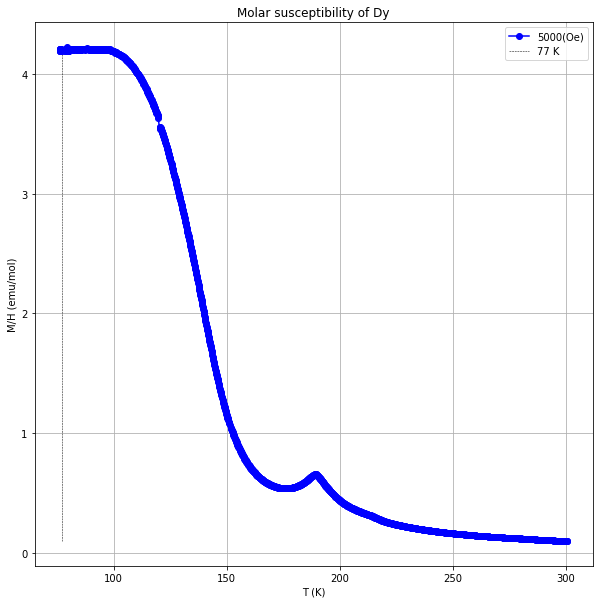

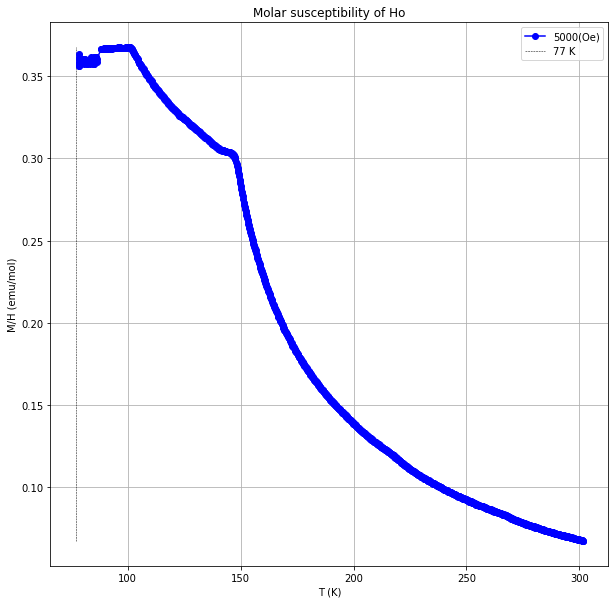

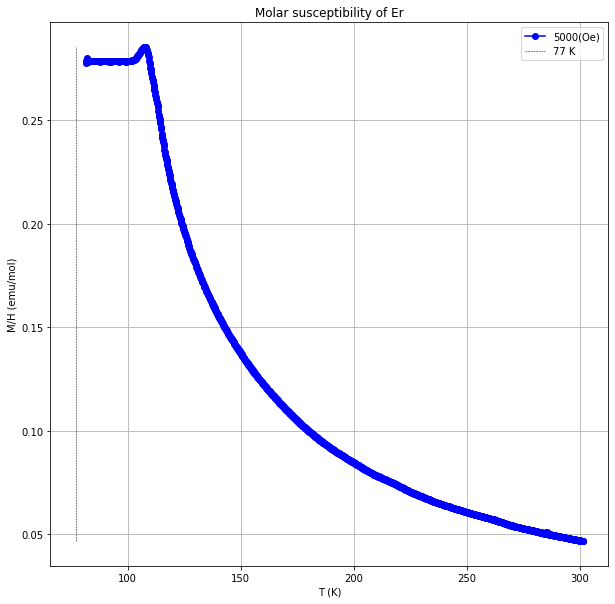

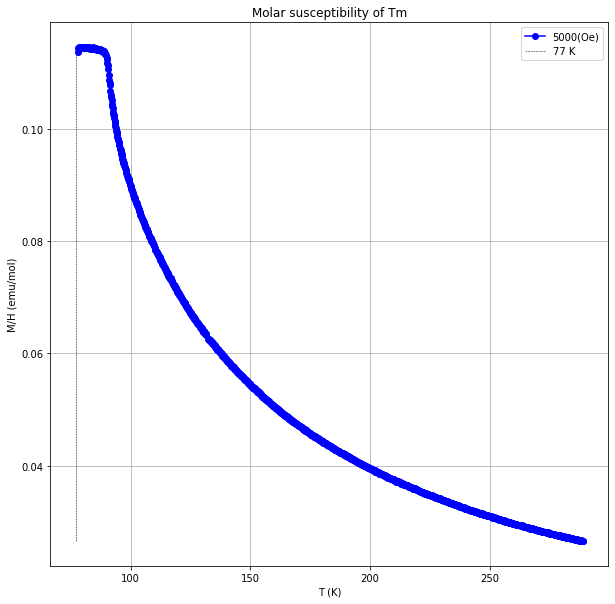

In [123]:
Tb.draw_susceptibility()
Dy.draw_susceptibility()
Ho.draw_susceptibility()
Er.draw_susceptibility()
Tm.draw_susceptibility()

以下はすべて上記グラフを目測して得た値である。ただし、降温時は反強磁性→強磁性となること、すなわちネール温度がキュリー温度より高いということを使った。また、グラフから読み取れないこともあったので、参考文献に記したウェブサイト(pdf)などを参考にしたものもある。
### Tb
キュリー温度 : 250 K  
ネール温度はキックが見えず、わからなかった。
### Dy
キュリー温度 : 160 K  
ネール温度 : 178 K
### Ho
キュリー温度 : 145 K  
ネール温度 : 148 K  
しかし、いろいろなウェブサイトを見ていると、キュリー温度は20 Kのようだ。
### Er
キュリー温度がどこかわからなかった。ウェブサイトで調べたところ、20 Kと書かれていた。  
ネール温度 : 110 K
### Tm
キュリー温度はわからなかった。ウェブサイトで調べたところ、38 Kと書かれていた。
ネール温度 : 90 K

# 問題（４）
Tb,Dy,Ho,Er,Tmの磁化率の逆数（逆帯磁率χ<sup>-1</sup> ）の温度依存性をプロットしたグラフを作成せよ。  
Tb,Dy,Ho,Er,Tmの磁気相転移温度以上の温度領域（常磁性領域）でキュリー・ワイス則(χ<sup>-1</sup> = H/M = (T - T<sub>θ</sub>/C, C: キュリー定数）を用いてデータを解析（fitting）を行い、有効磁子数（𝑝eff = 𝑔𝐽 𝐽(𝐽 + 1) ≅ 8𝐶 ）とワイス温度（𝑇𝜃 = 𝑔𝐽 − 1 2𝐽eff𝐽(𝐽 + 1)/3𝑘B）を求めよ。

## 回答
プロットしたグラフは以下である。

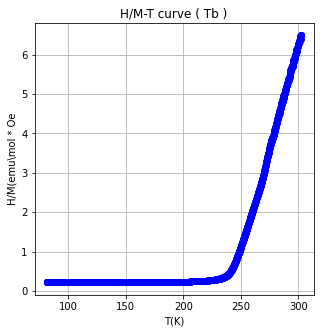

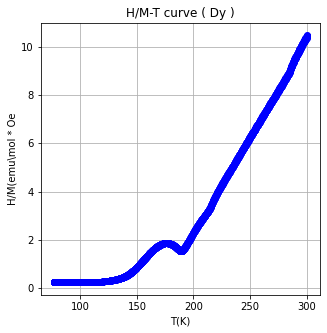

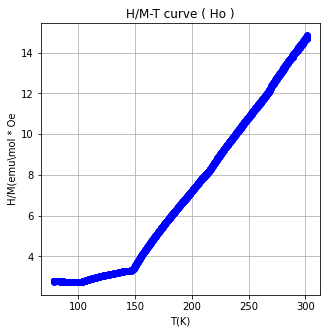

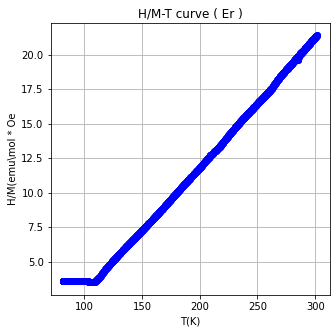

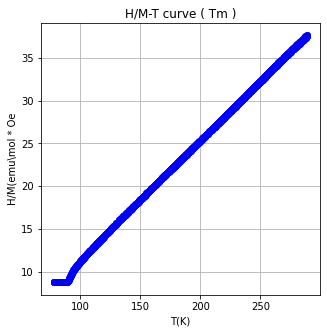

In [124]:
Tb.draw_inverse_susceptibility()
Dy.draw_inverse_susceptibility()
Ho.draw_inverse_susceptibility()
Er.draw_inverse_susceptibility()
Tm.draw_inverse_susceptibility()

プロットの結果から、磁気相転移温度をそれぞれ適当に設定し、それ以上の温度の領域でfittingする。

Tb
キュリー定数C = 9.46751275387836
ワイス温度T_θ = 240.72707216589214
有効磁子数 p_eff = 8.702878950728136
Dy
キュリー定数C = 12.449458720923628
ワイス温度T_θ = 172.2952075789897
有効磁子数 p_eff = 9.979763011584446
Ho
キュリー定数C = 13.543475356759588
ワイス温度T_θ = 102.48952417251212
有効磁子数 p_eff = 10.409025067415138
Er
キュリー定数C = 10.773548458867618
ワイス温度T_θ = 71.89217645066307
有効磁子数 p_eff = 9.283770121612283
Tm
キュリー定数C = 7.182849329083169
ワイス温度T_θ = 18.22035466857292
有効磁子数 p_eff = 7.580421797806857


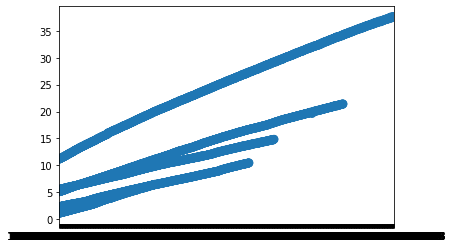

In [125]:

Tb.phase_transition_temperature = 250 # [K]
Tb.fitting()
Dy.phase_transition_temperature = 200
Dy.fitting()
Ho.phase_transition_temperature = 175
Ho.fitting()
Er.phase_transition_temperature = 125
Er.fitting()
Tm.phase_transition_temperature = 100 # [K]
Tm.fitting()